In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig

# Load Data

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated.csv"

In [3]:
sample_threshold = 5

df = DatasetProcessor.process_dataset(dataset_path, sample_threshold=sample_threshold)

2024-01-17 14:01:17.711 | DEBUG    | triagerx.dataset.processor:load_dataframe:8 - Loading dataframe: /home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated.csv
2024-01-17 14:01:18.617 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:24 - Filtering developers based on minimum contribution: 5...
2024-01-17 14:01:18.624 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:32 - Generating 'text' field...
2024-01-17 14:01:18.679 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:44 - Dropping rows with 'text' length < 15...
2024-01-17 14:01:18.687 | DEBUG    | triagerx.dataset.processor:clean_data:13 - Cleaning dataset...


<Axes: xlabel='assignees'>

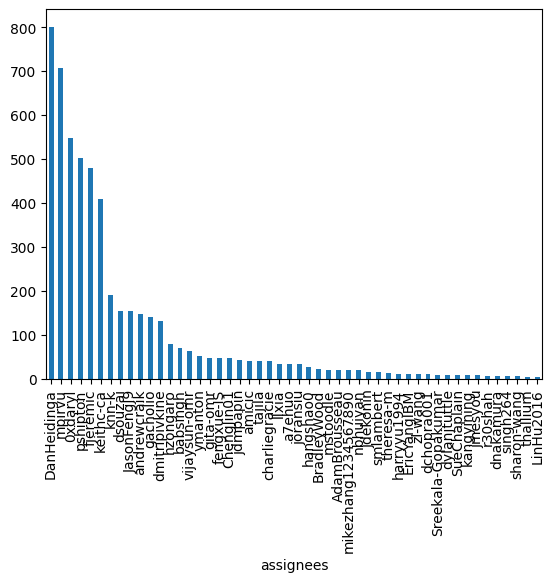

In [4]:
df["assignees"].value_counts().plot(kind="bar")

In [5]:
np.random.seed(42)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["owner_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df["owner_id"])

In [9]:
assert len(train_df.owner_id.unique()) == len(train_df.owner_id.unique()) == len(valid_df.owner_id.unique())

# Training

In [10]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import torch

In [12]:
class_counts = np.bincount(train_df["owner_id"])
num_samples = sum(class_counts)
labels = train_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [13]:
learning_rate = 1e-6
epochs = 50
batch_size = 15

# Create sampler
# counts = np.bincount(train_df["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[train_df["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"
model_name = model.__class__.__name__

output_file = f"{model_name}_{sample_threshold}_stratify_comp-labels_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    }
}

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=train_df,
    validation_dataset=valid_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    wandb=wandb_config
)

trainer = ModelTrainer(train_config)
trainer.train(model=model)

2024-01-17 14:02:41.830 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-17 14:02:41.833 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-17 14:02:48.222 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-17 14:02:48.225 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-17 14:02:50.087 | DEBUG    | triagerx.trainer.model_trainer:train:33 - Initializing wandb...
wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


2024-01-17 14:02:57.761 | DEBUG    | triagerx.trainer.model_trainer:train:48 - Selected compute device: cuda
  0%|          | 0/243 [00:00<?, ?it/s]/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 243/243 [01:31<00:00,  2.66it/s]
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-01-17 14:04:37.416 | INFO     | triagerx.trainer.model_trainer:_log_step:147 - Epochs: 1 | Train Loss:  0.260                   

f1-score,▁▁▂▃▄▄▅▅▅▅▅▆▆▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇▇██▇██
precision,▁▃▄▄▅▆▇▇▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇██▇▇█▇▇████▇██▇██
recall,▁▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇██▇
train_acc,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
train_loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▂▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
f1-score,0.29976
precision,0.3
recall,0.35617
train_acc,0.97302


# Evaluation

In [14]:
import torch
from triagerx.evaluation.evaluator import Evaluator

In [15]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)
model.load_state_dict(torch.load(output_path))

evaluator = Evaluator()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from torch.utils.data import DataLoader
from triagerx.dataset.triage_dataset import TriageDataset

dataset = TriageDataset(test_df, model.tokenizer())

2024-01-17 15:27:45.759 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-17 15:27:45.761 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


In [17]:
loader = DataLoader(dataset, 15)

In [18]:
device = "cuda"
all_preds = []
all_labels = []

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input["attention_mask"].to(device)
        input_id = val_input["input_ids"].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label.long())
        # total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()

        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(val_label.cpu().numpy())
        
        # total_acc_val += acc

In [19]:
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

In [20]:
set(all_labels) - set(all_preds)

{0, 3, 13, 18, 20, 22, 23, 25, 28, 32, 35, 38, 41, 45, 46, 47, 48}

In [21]:
# Top 3 Predictions
evaluator.calculate_top_k_accuray(model, k=3, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-17 15:28:25.986 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-17 15:28:39.155 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 3 score...
2024-01-17 15:28:39.159 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 3 score: 0.773067331670823


0.773067331670823

In [22]:
# Top 5 Predictions
evaluator.calculate_top_k_accuray(model, k=5, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-17 15:28:39.236 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-17 15:28:52.310 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 5 score...
2024-01-17 15:28:52.314 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 5 score: 0.8678304239401496


0.8678304239401496